In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

def bits_to_MiB(row):
	"""
	Converts a value from bits to Mebibytes (MiB).

	Parameters:
	row (float or str): The value to be converted. If a string is provided, it should contain the unit 'MiB'.

	Returns:
	float: The converted value in Mebibytes (MiB).
	"""
	# verify if has string ' MiB'
	if 'MiB' in str(row):
		row = row.replace(' MiB', '')
		row = float(row)
	else:
		row = float(row) / np.power(2, 20)
	return row


def MHz_to_GHz(row):
	"""
	Convert a frequency value from MHz to GHz.

	Parameters:
	row (str or float): The frequency value to be converted.

	Returns:
	float: The converted frequency value in GHz.
	"""
	# verify if has string ' GHz'
	if 'GHz' in str(row):
		row = row.replace(' GHz', '')
		# convert to float
		row = float(row)
	else:
		row = row.replace(' MHz', '')
		row = float(row) / 1000
	return row

def train_test_split(dataset_df: pd.DataFrame, test_size=0.2):
	"""
	Splits the dataset into training and testing sets based on the specified test size.

	Args:
		dataset_df (pd.DataFrame): The dataset to be split.
		test_size (float): The proportion of the dataset to be used for testing. Default is 0.2.

	Returns:
		tuple: A tuple containing the training and testing datasets.

	"""
	df = dataset_df.copy()
	# train_temp_df: PCS only for training
	# 13th Gen Intel(R) Core(TM) i5-1335U because is not present in passmark score for comparison papper
	# 12th Gen Intel(R) Core(TM) i5-12400F because the score is too high for the comparison papper
	exclude = ['13th Gen Intel(R) Core(TM) i5-1335U', '12th Gen Intel(R) Core(TM) i5-12400F']
	train_temp_df = df[df['brand_raw_target'].isin(exclude) | df['brand_raw'].isin(exclude)]
	df = df.drop(train_temp_df.index)
	# test_temp_df: PCS only for testing
	test_temp_df = df[df['brand_raw_target'].isin(['Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz','Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz'])]
	df = df.drop(test_temp_df.index)
	# Get random benchmark and brand_raw until test_size is reached
	# test_df: PCS that are in the training set but certain benchmarks are reserved for testing
	test_df = pd.DataFrame()
	while (test_df.shape[0] + test_temp_df.shape[0]) / dataset_df.shape[0] < test_size:
		benchmark = df['benchmark'].unique()[np.random.randint(0, df['benchmark'].nunique())]
		brand_raw = df['brand_raw_target'].unique()[np.random.randint(0, df['brand_raw_target'].nunique())]
		rows = df[(df['benchmark'] == benchmark) & (df['brand_raw_target'] == brand_raw)]
		if rows.shape[0] == 1:
			continue
		test_df = pd.concat([test_df, rows])
		df = df.drop(rows.index)
		# Remove from training set every row that has brand_raw and benchmark to not cheat on the test set
		rows_del = df[(df['benchmark'] == benchmark) & (df['brand_raw'] == brand_raw)]
		df = df.drop(rows_del.index)
	test_df = pd.concat([test_df, test_temp_df])
	train_df = pd.concat([df, train_temp_df])
	return train_df, test_df

In [80]:
results_df = pd.read_csv('../results/execution_time_md.csv')
results_savio_df = pd.read_csv('../results_savio/execution_time_md.csv')
results_df = pd.concat([results_df, results_savio_df], ignore_index=True)
# Preprocessing
results_df['total_cpu_usage'] = results_df['total_cpu_usage'].str.replace('%', '').astype(float) / 100
results_df['max_ram_usage'] = results_df['max_ram_usage'] / 1024
results_df['l2_cache_size'] = results_df['l2_cache_size'].apply(bits_to_MiB)
results_df['l3_cache_size'] = results_df['l3_cache_size'].apply(bits_to_MiB)
results_df['ghz_actual_friendly'] = results_df['hz_actual_friendly'].apply(MHz_to_GHz)
results_df['ghz_advertised_friendly'] = results_df['hz_advertised_friendly'].str.replace('GHz', '').astype(float)
results_df = results_df.drop(columns=['hz_actual_friendly', 'hz_advertised_friendly'])
results_df = results_df[~results_df['benchmark'].isin(['MATRIX_MULT', 'MATRIX_MULT2', 'MATRIX_MULT3'])]

# Benchmarks

In [81]:
print("# benchmarks:",len(results_df["benchmark"].unique()))
results_df["benchmark"].unique()

# benchmarks: 92


array(['KNP', 'KNPS_FILE_1_500_1000', 'KNPS_FILE_1_500_10000',
       'KNPS_FILE_1_1000_1000', 'KNPS_FILE_1_1000_10000',
       'KNPS_FILE_1_2000_1000', 'KNPS_FILE_1_5000_1000',
       'KNPS_FILE_1_5000_10000', 'KNPS_FILE_1_10000_1000',
       'KNPS_FILE_1_10000_10000', 'KNPS_FILE_2_500_1000',
       'KNPS_FILE_2_500_10000', 'KNPS_FILE_2_1000_1000',
       'KNPS_FILE_2_1000_10000', 'KNPS_FILE_2_2000_1000',
       'KNPS_FILE_2_2000_10000', 'KNPS_FILE_2_5000_10000',
       'KNPS_FILE_3_50_1000', 'KNPS_FILE_3_50_10000',
       'KNPS_FILE_4_50_1000', 'KNPS_FILE_4_50_10000',
       'KNPS_FILE_5_50_1000', 'KNPS_FILE_5_50_10000',
       'KNPS_FILE_12_20_1000', 'KNPS_FILE_13_20_1000',
       'KNPS_FILE_14_50_1000', 'KNPS_FILE_15_50_1000',
       'KNPS_FILE_16_50_1000', 'TSP', 'TSP2', 'TSP3', 'TSP4', 'TSPd198',
       'TSPd493', 'TSPd657', 'TSPd1291', 'TSPd1655', 'TSPd2103',
       'TSPfl417', 'TSPfl1400', 'TSPfl1577', 'TSPfl3795', 'TSPgil262',
       'TSPkroA150', 'TSPkroA200', 'TSPkroB150', '

## PCs

In [82]:
results_df[['brand_raw','vendor_id_raw','arch','count']].drop_duplicates()

,brand_raw,vendor_id_raw,arch,count
0,13th Gen Intel(R) Core(TM) i5-1335U,GenuineIntel,X86_64,12
439,12th Gen Intel(R) Core(TM) i5-12400F,GenuineIntel,X86_64,12
488,11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz,GenuineIntel,X86_64,8
519,Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz,GenuineIntel,X86_64,8
537,Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz,GenuineIntel,X86_64,8
556,Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz,GenuineIntel,X86_64,12
1011,Intel(R) Xeon(R) CPU E5-2670 v3 @ 2.30GHz,GenuineIntel,X86_64,24
1031,Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz,GenuineIntel,X86_64,28
1061,Intel(R) Xeon(R) CPU E5-2650 v4 @ 2.20GHz,GenuineIntel,X86_64,24
1472,Intel(R) Xeon(R) CPU E5-2623 v3 @ 3.00GHz,GenuineIntel,X86_64,8


In [83]:
results_df[['total_time','total_cpu_usage','max_ram_usage']].describe()

,total_time,total_cpu_usage,max_ram_usage
count,2798.000000,2798.000000,2798.000000
mean,27.342169,0.989571,119.577448
std,74.094264,0.004875,384.174978
min,0.090000,0.930000,10.199219
25%,0.572500,0.990000,18.491211
50%,6.735000,0.990000,24.078125
75%,23.800000,0.990000,53.543945
max,898.440000,1.010000,3284.496094


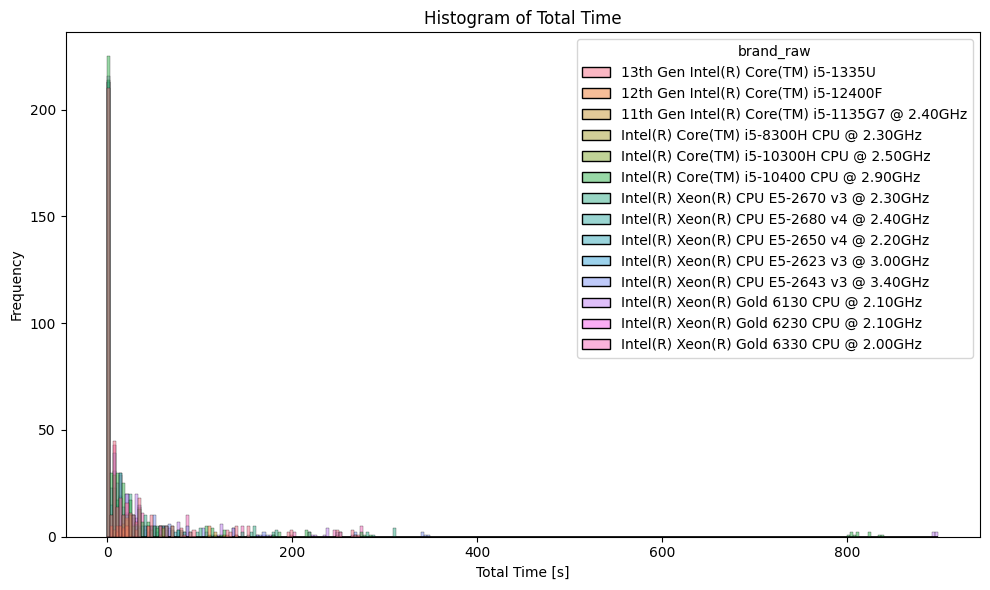

In [84]:
plt.figure(figsize=(10, 6))
sns.histplot(results_df, x='total_time', hue='brand_raw')
plt.title('Histogram of Total Time')
plt.xlabel('Total Time [s]')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

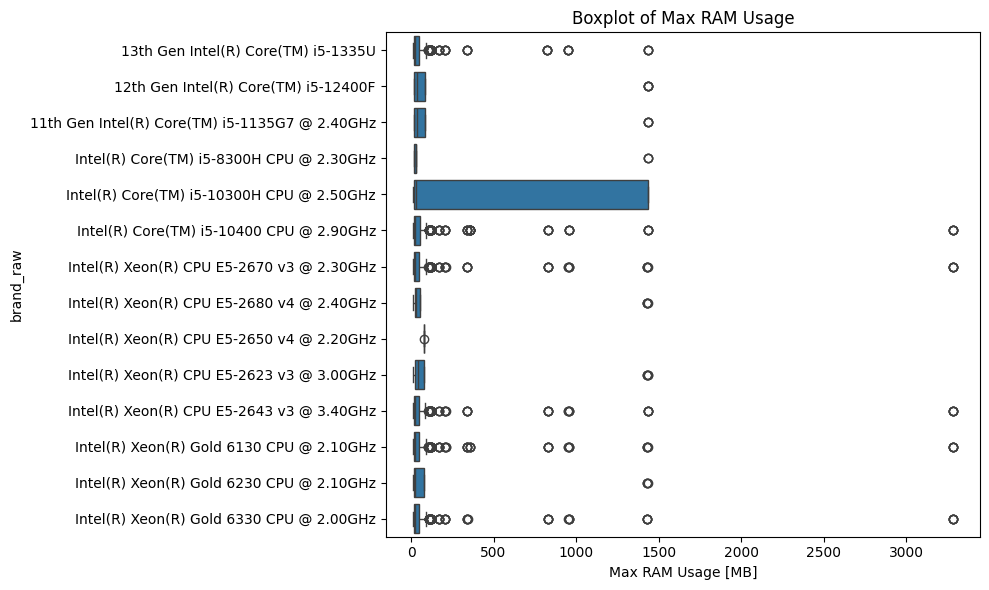

In [85]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='max_ram_usage', y='brand_raw')
plt.title('Boxplot of Max RAM Usage')
plt.xlabel('Max RAM Usage [MB]')

plt.tight_layout()
plt.show()

# Pre-processing input data

In [86]:
passmark_scores = [
	{"brand_raw": '13th Gen Intel(R) Core(TM) i5-1335U', "score": 3437}, # New passmark score (not present in the comparison paper)
	{"brand_raw": '12th Gen Intel(R) Core(TM) i5-12400F', "score": 3511},
	{"brand_raw": '11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz', "score": 2731},
	{"brand_raw": 'Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz', "score": 2589},
	{"brand_raw": 'Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz', "score": 2630},
	{"brand_raw": 'Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz', "score": 2319},
	{"brand_raw": 'Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz', "score": 1952},
	{"brand_raw": 'Intel(R) Xeon(R) CPU E5-2650 v4 @ 2.20GHz', "score": 1507},
	{"brand_raw": 'Intel(R) Xeon(R) CPU E5-2670 v3 @ 2.30GHz', "score": 1702},
	{"brand_raw": 'Intel(R) Xeon(R) CPU E5-2623 v3 @ 3.00GHz', "score": 1868},
	{"brand_raw": 'Intel(R) Xeon(R) CPU E5-2643 v3 @ 3.40GHz', "score": 2099},
	{"brand_raw": 'Intel(R) Xeon(R) Gold 6130 CPU @ 2.10GHz', "score": 1880},
	{"brand_raw": 'Intel(R) Xeon(R) Gold 6230 CPU @ 2.10GHz', "score": 2285},
	{"brand_raw": 'Intel(R) Xeon(R) Gold 6330 CPU @ 2.00GHz', "score": 2034},	
]
passmark_scores_df = pd.DataFrame(passmark_scores, columns=['brand_raw', 'score'])
if not os.path.exists('csv/passmark_scores.csv'):
	passmark_scores_df.to_csv('csv/passmark_scores.csv', index=False)

In [87]:
results_df = results_df.merge(passmark_scores_df, on='brand_raw', how='left')

In [88]:
# Syscalls
syscalls = set()
syscalls_folder = '../results/X86_64/'
for filename in os.listdir(syscalls_folder):
	with open(syscalls_folder + filename, 'r') as file:
		for line in file:
			# check if line has "("
			if "(" in line:
				syscalls.add(line.split("(")[0])
syscalls_dict = {syscall: 0 for syscall in syscalls}

In [89]:
benchmarks = results_df['benchmark'].unique()
bechmarks_syscalls = {benchmark: syscalls_dict.copy() for benchmark in benchmarks}
for benchmark in benchmarks:
	benchmark_file = f'{syscalls_folder}strace_{benchmark}.txt'
	if not os.path.exists(benchmark_file):
		raise FileNotFoundError(f'{benchmark_file} not found')
	with open(benchmark_file, 'r') as file:
		for line in file:
			if "(" in line:
				syscall = line.split("(")[0]
				bechmarks_syscalls[benchmark][syscall] += 1

# Add the each syscalls of each benchmark to the results_df
bechmarks_syscalls_df = pd.DataFrame(bechmarks_syscalls).T.drop(columns=['exit_group','arch_prctl','execve']) # Remove syscalls that are always present
bechmarks_syscalls_df.index.name = 'benchmark'
bechmarks_syscalls_df = bechmarks_syscalls_df.reset_index()
results_df = results_df.merge(bechmarks_syscalls_df, on='benchmark', how='left')

In [90]:
# Make the target dataset
target_df = results_df[['total_time', 'brand_raw','l2_cache_size', 'l3_cache_size', 'l2_cache_line_size', 'l2_cache_associativity', 'ghz_advertised_friendly', 'benchmark','score']].copy()
# Rename columns to *_target
target_df = target_df.rename(columns={
	'total_time': 'total_time_target',
	'brand_raw': 'brand_raw_target',
	'count': 'count_target',
	'l2_cache_size': 'l2_cache_size_target',
	'l3_cache_size': 'l3_cache_size_target',
	'l2_cache_line_size': 'l2_cache_line_size_target',
	'l2_cache_associativity': 'l2_cache_associativity_target',
	'ghz_advertised_friendly': 'ghz_advertised_friendly_target',
	'score': 'score_target'
})

dataset_df = pd.merge(results_df, target_df, how='inner', on='benchmark')
dataset_df = dataset_df[dataset_df['brand_raw'] != dataset_df['brand_raw_target']]
dataset_df = dataset_df[~dataset_df['benchmark'].isin(['MATRIX_MULT', 'MATRIX_MULT2', 'MATRIX_MULT3'])]

In [91]:
# Memory Usage
memory_df = pd.read_csv('../results/memory_usage.csv')
memory_savio_df = pd.read_csv('../results_savio/memory_usage.csv')
memory_df = pd.concat([memory_df, memory_savio_df], ignore_index=True)
# Get initial RAM usage of the system for each ['brand_raw','benchmark','vendor_id_raw','arch'] execution where time is close to 0
initial_memory_df = memory_df.drop([
	'count',
	'l2_cache_size',
	'l3_cache_size',
	'hz_advertised_friendly',
	'l2_cache_line_size',
	'l2_cache_associativity',
	'hz_actual_friendly',
	'lib',
	'dirty',
	'time'
], axis=1).groupby(
	['brand_raw', 'benchmark', 'vendor_id_raw', 'arch']
).mean().reset_index()
# Convert to MiB
initial_memory_df[['rss','vms','shared', 'text', 'data']] = initial_memory_df[['rss','vms','shared', 'text', 'data']] / np.power(2, 20)
# Get the max RAM usage for each ['brand_raw','benchmark','vendor_id_raw','arch'] execution
dataset_df = dataset_df.merge(initial_memory_df, on=['brand_raw', 'benchmark', 'vendor_id_raw', 'arch'])

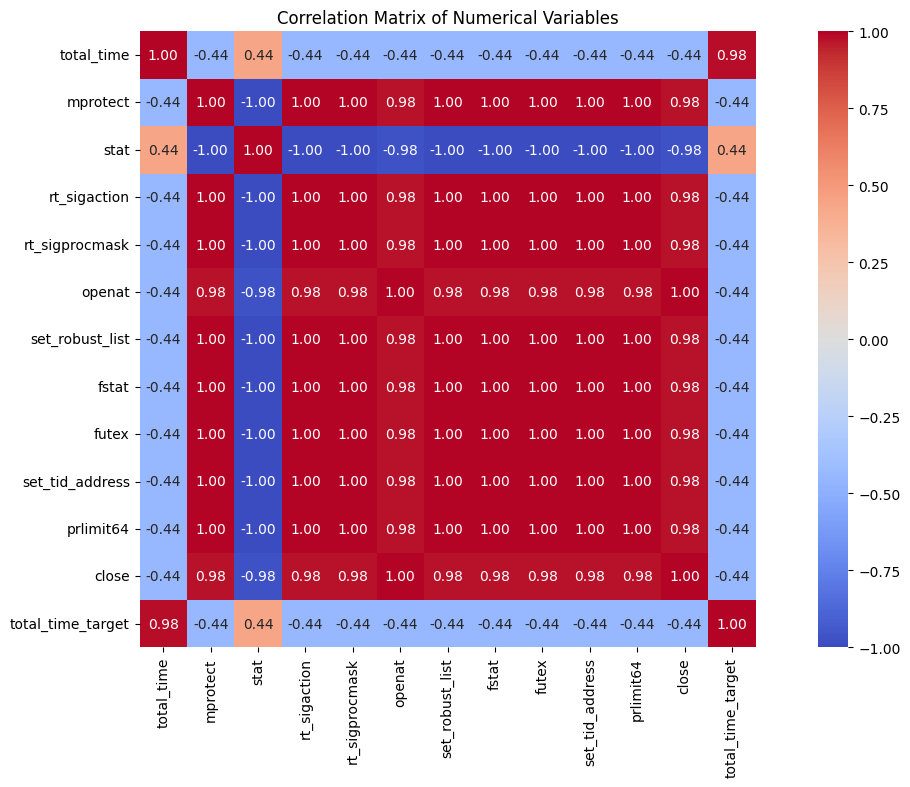

In [92]:
correlation_matrix = dataset_df[
	dataset_df.drop([
		'brand_raw', 
		'benchmark', 
		'vendor_id_raw', 
		'arch',
		'brand_raw_target',
	],axis=1).columns
].corr()

# Filtra las columnas con correlación significativa con 'total_time_target'
target_correlation = correlation_matrix['total_time_target']
filtered_columns = target_correlation[
    (target_correlation >= 0.4) | (target_correlation <= -0.4)
].index

# Crea la matriz de correlación filtrada
filtered_correlation_matrix = correlation_matrix.loc[filtered_columns, filtered_columns]

plt.figure(figsize=(16, 8))
sns.heatmap(filtered_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

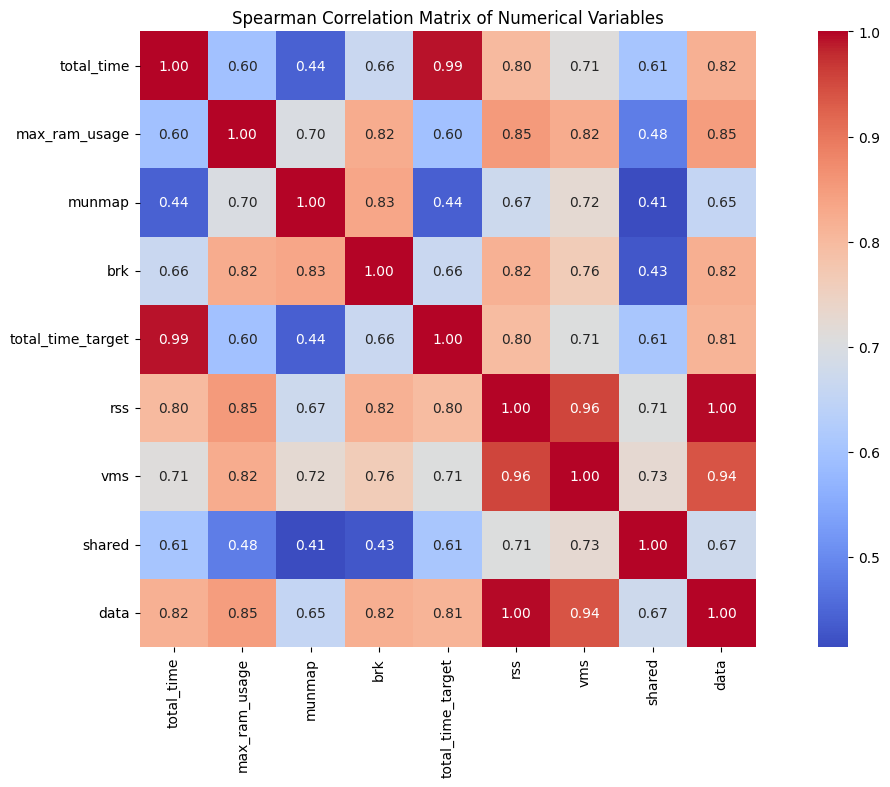

In [93]:
# Spearman correlation
spearman_correlation_matrix = dataset_df[
	dataset_df.drop([
		'brand_raw', 
		'benchmark', 
		'vendor_id_raw', 
		'arch',
		'brand_raw_target',
	],axis=1).columns
].corr(method='spearman')

# Filtra las columnas con correlación significativa con 'total_time_target'
target_correlation = spearman_correlation_matrix['total_time_target']
filtered_columns = target_correlation[
    (target_correlation >= 0.40) | (target_correlation <= -0.40)
].index

# Crea la matriz de correlación filtrada
filtered_correlation_matrix = spearman_correlation_matrix.loc[filtered_columns, filtered_columns]

plt.figure(figsize=(16, 8))
sns.heatmap(filtered_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Spearman Correlation Matrix of Numerical Variables')
plt.show()

/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5278: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


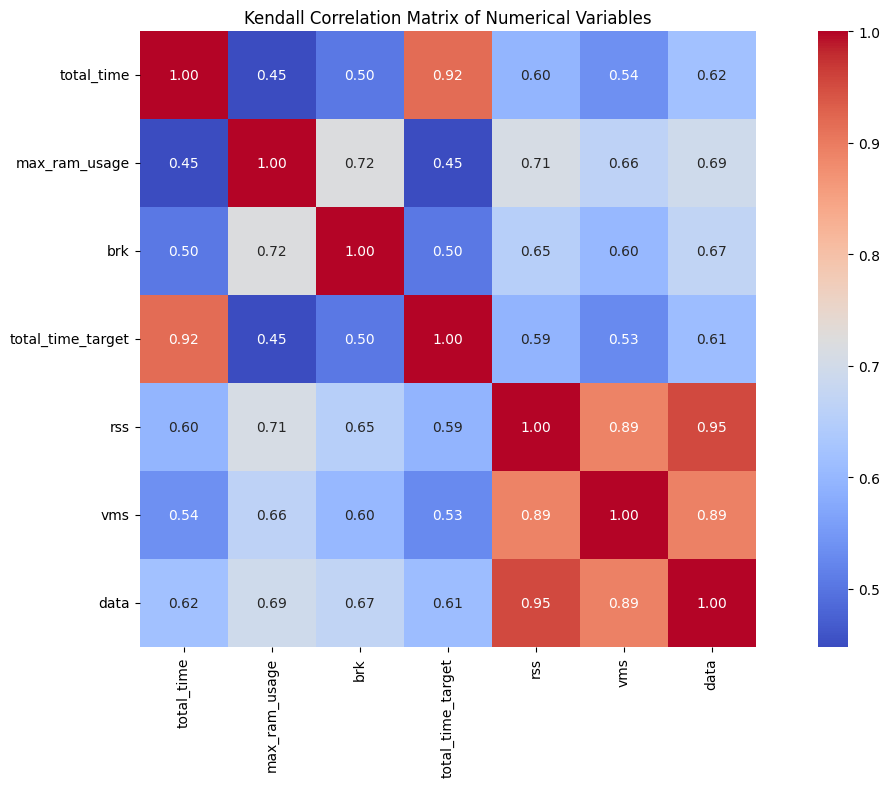

In [94]:
# kendall correlation
kendall_correlation_matrix = dataset_df[
	dataset_df.drop([
		'brand_raw', 
		'benchmark', 
		'vendor_id_raw', 
		'arch',
		'brand_raw_target',
	],axis=1).columns
].corr(method='kendall')

# Filtra las columnas con correlación significativa con 'total_time_target'
target_correlation = kendall_correlation_matrix['total_time_target']
filtered_columns = target_correlation[
    (target_correlation >= 0.4) | (target_correlation <= -0.4)
].index

# Crea la matriz de correlación filtrada
filtered_correlation_matrix = kendall_correlation_matrix.loc[filtered_columns, filtered_columns]

# Show the correlation matrix
plt.figure(figsize=(16, 8))
sns.heatmap(filtered_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Kendall Correlation Matrix of Numerical Variables')
plt.show()

# PCA

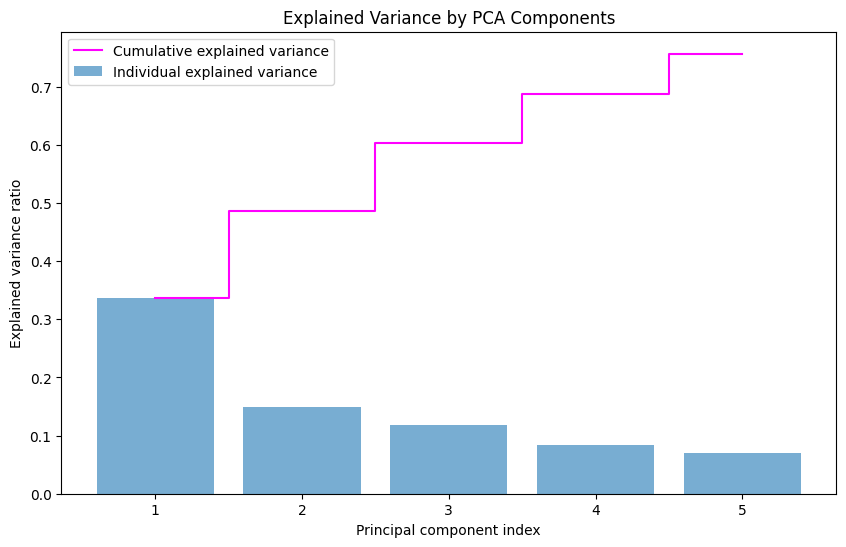

PC1: 0.33670839010767367 | PC2: 0.1498421093480742 | PC3: 0.11776497944982497 | PC4: 0.08328157904670132 | PC5: 0.06955632778012501
Total explained variance: 0.7571533857323992


In [95]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset_df.drop(['brand_raw', 'benchmark', 'vendor_id_raw', 'arch', 'brand_raw_target', 'count'], axis=1))

pca = PCA(n_components=5)
principal_components = pca.fit_transform(scaled_data)
explained_variance = pca.explained_variance_ratio_

pca_df = pd.DataFrame(data=principal_components, columns=[f"PC{i+1}" for i in range(principal_components.shape[1])])

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Individual explained variance')
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', color='magenta', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Explained Variance by PCA Components')
plt.legend(loc='best')
plt.show()

print(f"PC1: {explained_variance[0]} | PC2: {explained_variance[1]} | PC3: {explained_variance[2]} | PC4: {explained_variance[3]} | PC5: {explained_variance[4]}") 
print(f"Total explained variance: {np.sum(explained_variance)}")

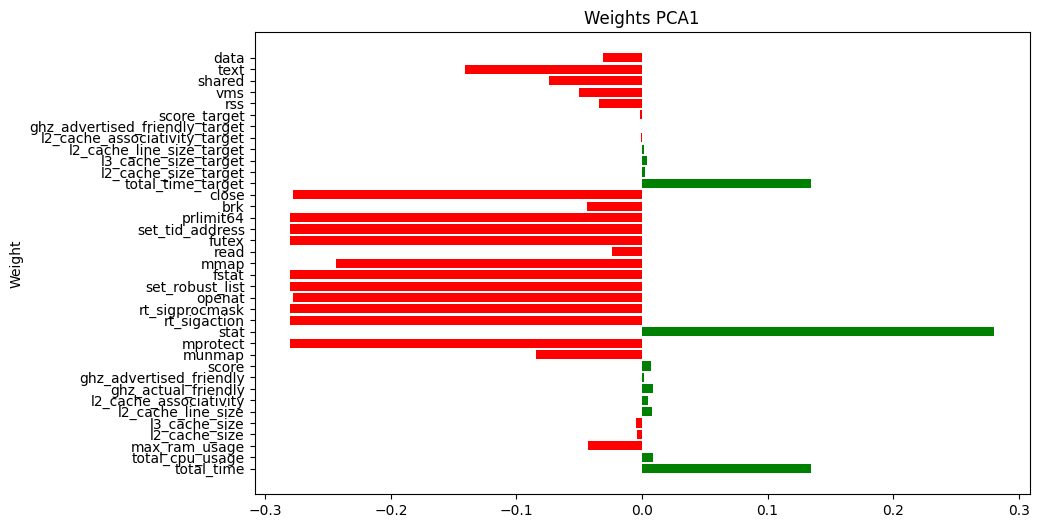

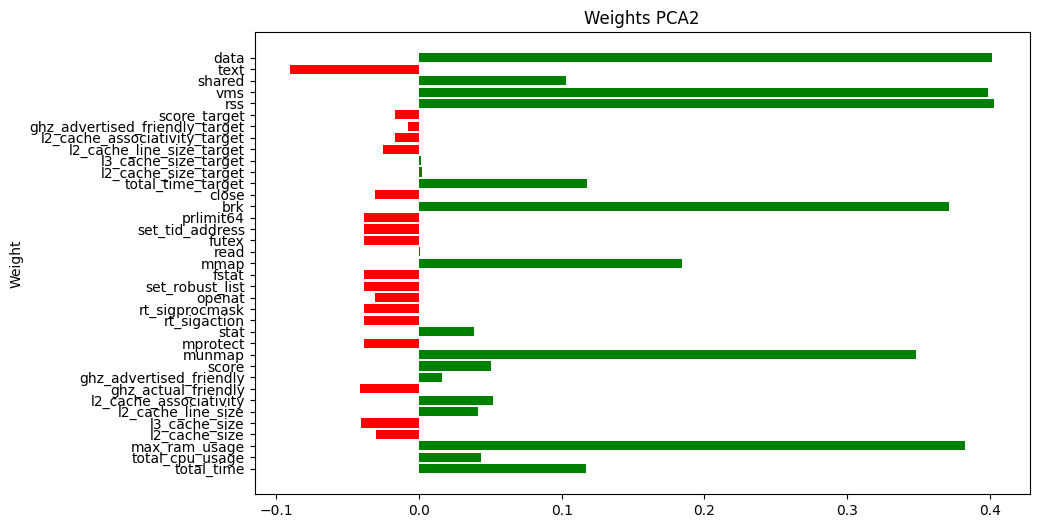

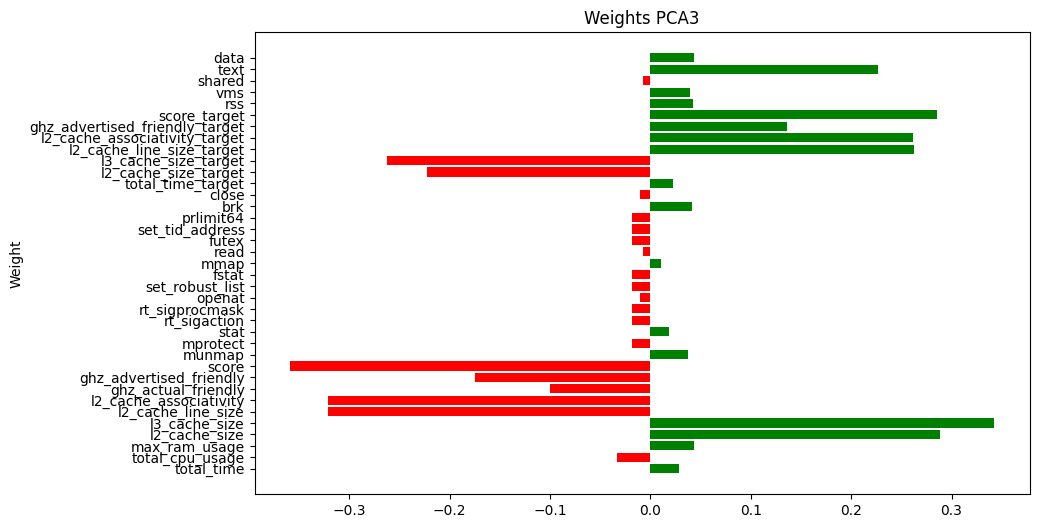

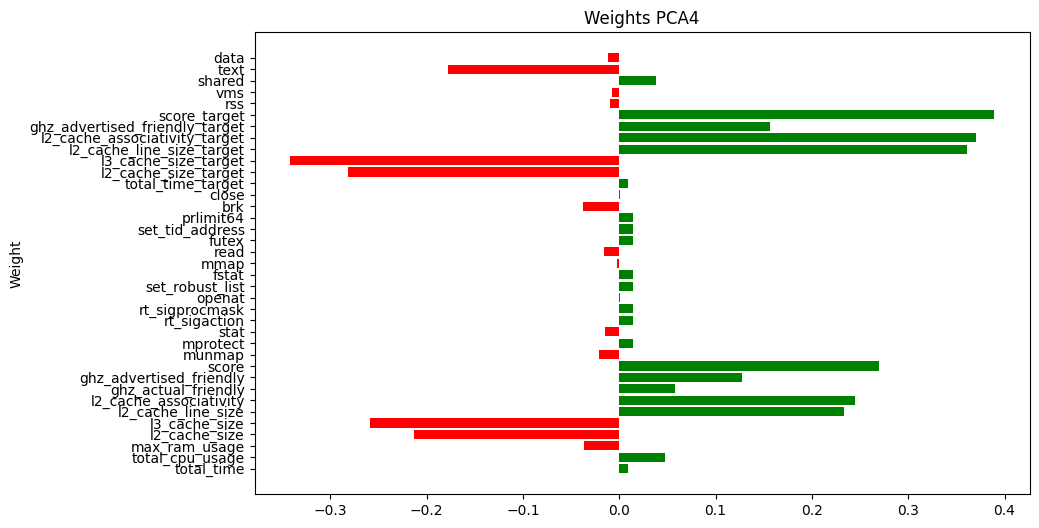

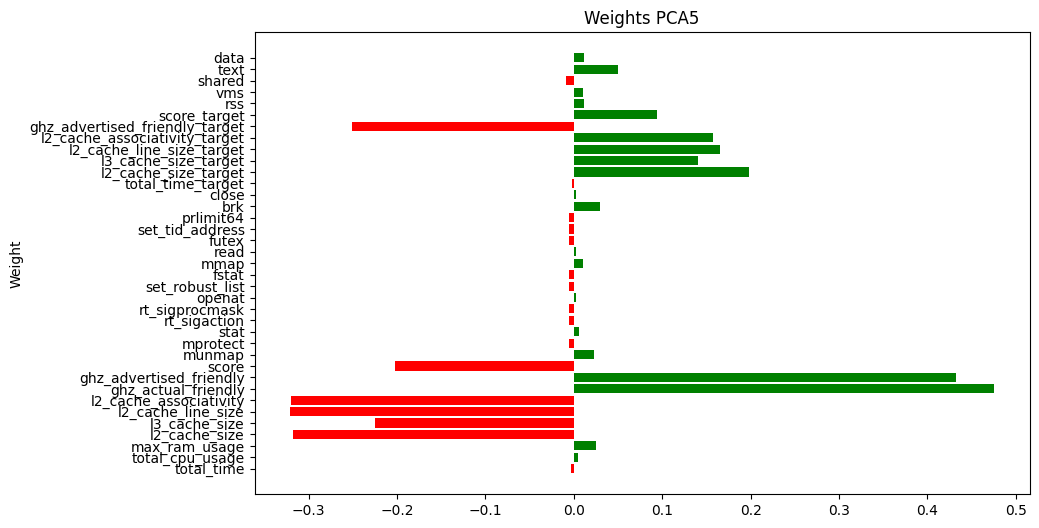

In [96]:
components = pca.components_
num_components = components.shape[0]
features = dataset_df.drop(['brand_raw', 'benchmark', 'vendor_id_raw', 'arch', 'brand_raw_target', 'count'], axis=1).columns

for i in range(num_components):
    plt.figure(figsize=(10, 6))
    component = components[i]
    colors = ['red' if val < 0 else 'green' for val in component]
    plt.barh(features, component, color=colors)
    plt.ylabel('Weight')
    plt.title(f'Weights PCA{i+1}')
    plt.show()

# Create train and test datasets

In [97]:
train_df, test_df = train_test_split(dataset_df, test_size=0.1)
if not os.path.exists('csv/train_df.csv') or not os.path.exists('csv/test_df.csv'):
	train_df.to_csv('csv/train_df.csv', index=False)
	test_df.to_csv('csv/test_df.csv', index=False)